In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
# Define the custom dataset to load and preprocess images
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            label = subfolder

            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Define the base directory and subfolders
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    r"3_long_blade_rotor", 
    r"3_short_blade_rotor", 
    r"Bird", 
    r"Bird+mini-helicopter", 
    r"drone", 
    r"rc_plane", 
]

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

In [18]:
# Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform)

In [24]:
# Encoding labels into numerical values and converting to categorical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset.labels)
num_classes = len(label_encoder.classes_)

In [19]:
train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

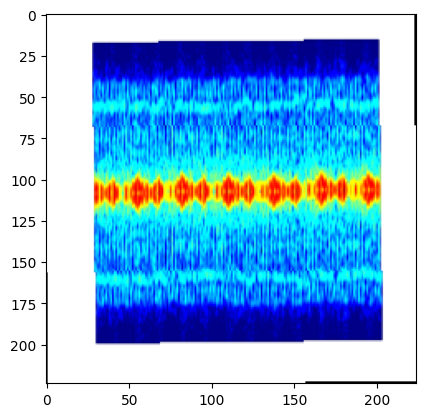

In [22]:
# Visualize one sample
sample_image, sample_label = next(iter(train_loader))
sample_image = sample_image[0]  # Take the first image from the batch
sample_image = sample_image.permute(1, 2, 0)  # Change the dimensions for plotting

# Inverse normalization if necessary (depends on how transforms are applied)
plt.imshow(sample_image)
plt.show()

In [27]:
# Model definitions using VGG16 and VGG19
class CustomVGG(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGG, self).__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(base_model.classifier[0].in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize models
vgg16_base = models.vgg16(pretrained=True)
for param in vgg16_base.parameters():
    param.requires_grad = False
model_vgg16 = CustomVGG(vgg16_base, num_classes=6)

vgg19_base = models.vgg19(pretrained=True)
for param in vgg19_base.parameters():
    param.requires_grad = False
model_vgg19 = CustomVGG(vgg19_base, num_classes=6)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\incha/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:18<00:00, 7.02MB/s] 
c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\incha/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [01:24<00:00, 6.79MB/s] 


In [28]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16.to(device)
model_vgg19.to(device)

CustomVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [29]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(model_vgg16.classifier.parameters(), lr=0.0001)
optimizer_vgg19 = optim.Adam(model_vgg19.classifier.parameters(), lr=0.0001)

In [30]:
# Learning rate scheduler
scheduler_vgg16 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)
scheduler_vgg19 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg19, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [33]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    model.train()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{model.__class__.__name__}.pt")
        
        model.train()

In [32]:
# Train VGG16 model
train_model(model_vgg16, train_loader, val_loader, criterion, optimizer_vgg16, scheduler_vgg16)

Epoch [1/50], Loss: 0.6928, Accuracy: 0.7479
Validation Loss: 0.4158, Accuracy: 0.8554
Epoch [2/50], Loss: 0.3326, Accuracy: 0.8872
Validation Loss: 0.2576, Accuracy: 0.9174
Epoch [3/50], Loss: 0.2645, Accuracy: 0.9097
Validation Loss: 0.1861, Accuracy: 0.9463
Epoch [4/50], Loss: 0.2174, Accuracy: 0.9270
Validation Loss: 0.1608, Accuracy: 0.9463
Epoch [5/50], Loss: 0.1856, Accuracy: 0.9372
Validation Loss: 0.1693, Accuracy: 0.9380
Epoch [6/50], Loss: 0.1653, Accuracy: 0.9442
Validation Loss: 0.1324, Accuracy: 0.9587
Epoch [7/50], Loss: 0.1461, Accuracy: 0.9534
Validation Loss: 0.1145, Accuracy: 0.9628
Epoch [8/50], Loss: 0.1380, Accuracy: 0.9551
Validation Loss: 0.1086, Accuracy: 0.9587
Epoch [9/50], Loss: 0.1262, Accuracy: 0.9566
Validation Loss: 0.1022, Accuracy: 0.9669
Epoch [10/50], Loss: 0.1176, Accuracy: 0.9636
Validation Loss: 0.1031, Accuracy: 0.9587
Epoch [11/50], Loss: 0.1198, Accuracy: 0.9597
Validation Loss: 0.1039, Accuracy: 0.9628
Epoch [12/50], Loss: 0.1059, Accuracy: 0.

KeyboardInterrupt: 